In [1]:
import gym
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from pprint import pprint
from collections import deque
import random

In [2]:
class Approx(nn.Module):
    def __init__(self, idim, h1dim, h2dim, odim):
        super().__init__()
        self.lin1 = nn.Linear(idim, h1dim)
        self.lin2 = nn.Linear(h1dim, h2dim)
        self.lin3 = nn.Linear(h2dim, odim)
    def forward(self, x):
        h = torch.tensor(x, dtype=torch.float)
        h = self.lin1(h)
        h = F.relu(h)
        h = self.lin2(h)
        h = F.relu(h)
        h = self.lin3(h)
        h = torch.tanh(h)*2
        return h
    def explore(self, x, noise=0.5):
        h = self.forward(x)
        nor = torch.distributions.Normal(torch.zeros(h.shape, dtype=torch.float), torch.ones(h.shape, dtype=torch.float)*noise)
        h += nor.sample()
        h = torch.clamp(h, -2, 2)
        return h.detach().numpy()
    
class Q(nn.Module):
    def __init__(self, idim, h1dim, h2dim, odim):
        super().__init__()
        self.lin1 = nn.Linear(idim, h1dim)
        self.lin2 = nn.Linear(h1dim, h2dim)
        self.lin3 = nn.Linear(h2dim, odim)
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float)
        h = self.lin1(x)
        h = F.relu(h)
        h = self.lin2(h)
        h = F.relu(h)
        h = self.lin3(h)
        
        return h

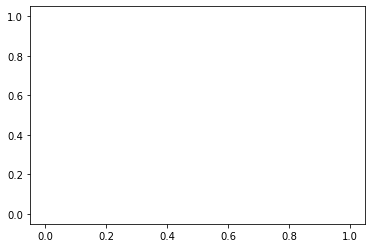

In [28]:
plt.plot(final_rs[::1])

In [29]:
env.close()

In [3]:
env = gym.make('Pendulum-v0')
observation = env.reset()
for t in range(200):
        env.render()
        action, logprobs = agent.act(observation, stdnew)
        observation, reward, done, info = env.step(action)
        if done:
            break
        time.sleep(0.01)
        print(t, "/200", end='\r')
env.close()
cv2.destroyAllWindows()

NameError: name 'agent' is not defined

In [4]:
env = gym.make('Pendulum-v0')

In [5]:
obsdim = env.observation_space.shape[0]
adim = env.action_space.shape[0]
q = Q(obsdim+adim, 10, 4, 1)
pi = Approx(obsdim, 10, 4, adim)
qopt = torch.optim.Adam(q.parameters(), lr=1e-2)
piopt = torch.optim.Adam(pi.parameters() , lr=5e-3)

In [6]:
obsdim, adim

(3, 1)

In [7]:
import copy
qtarget = copy.deepcopy(q)
pitarget = copy.deepcopy(pi)

In [8]:
env.close()
cv2.destroyAllWindows()
a = torch.tensor(env.observation_space.sample()).unsqueeze(0)
b = torch.tensor(env.action_space.sample()).unsqueeze(0)
print(a.shape, b.shape)
q(torch.cat((a, b), dim=-1)), pi(a)

torch.Size([1, 3]) torch.Size([1, 1])


<ipython-input-2-f40b6d530723>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float)
<ipython-input-2-f40b6d530723>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = torch.tensor(x, dtype=torch.float)


(tensor([[0.3897]], grad_fn=<AddmmBackward>),
 tensor([[0.5932]], grad_fn=<MulBackward0>))

In [9]:
gamma = 0.90
gmm = torch.zeros(200, 200, dtype=torch.float)
for i in range(gmm.shape[0]):
    umn = 1
    for j in range(i, gmm.shape[1]):
        gmm[i, j] = umn
        umn *= gamma

In [10]:
oldobsbuff, abuff, rbuff, obsbuff = deque([]), deque([]), deque([]), deque([])

In [36]:
env = gym.make('Pendulum-v0')
final_rs = []
eps = 15000
action = 0
lpq  = LowPassFilter(1-1/100)
lppi = LowPassFilter(1-1/20)
lpr  = LowPassFilter(1-1/20)
bsize = 512
buff_size = 100000

for ep in range(eps):
    observation = env.reset()
    
    #act and collect
    rnotdisc = []
    stdnew = ep/eps*0.05 + (1-ep/eps)*0.7
    for t in range(200):
        if ep > 1000:
            action = pi.explore(observation, stdnew)
        else:
            action = env.action_space.sample()
        oldobs = observation
        observation, reward, done, info = env.step(action)
        oldobsbuff.append(oldobs)
        abuff.append(action)
        rnotdisc.append(reward)
        obsbuff.append(observation)
        if done:
            break
    rnotdisc = torch.tensor(rnotdisc, dtype=torch.float)
    rdisc = gmm@rnotdisc
    lpr.step(rnotdisc.sum().item()/len(rnotdisc))
    for i in range(len(rdisc)):
        rbuff.append(rdisc[i].item())
    for i in range(len(rbuff)-buff_size):
        oldobsbuff.popleft()
        abuff.popleft()
        rbuff.popleft()
        obsbuff.popleft()
        
            
    #get batch
    if ep < 10:
        continue
    for istep in range(5):
        oldobs, a, r, obs = [], [], [], []
        lidx = random.sample(range(0, len(rbuff)), bsize)
        if ep==10:
            print(len(lidx), "len")
        for idx in lidx:
            oldobs.append(oldobsbuff[idx])
            a.append(abuff[idx])
            r.append(rbuff[idx])
            obs.append(obsbuff[idx])
        oldobs = torch.tensor(oldobs, dtype=torch.float)
        a      = torch.tensor(a, dtype=torch.float)
        r      = torch.tensor(r, dtype=torch.float)
        obs    = torch.tensor(obs, dtype=torch.float)

        #train
        in1 = torch.cat((obs, pitarget(obs).detach()), dim=1)
        in2 = torch.cat((oldobs,                   a), dim=1)
        print(in1.shape, in2.shape, "s", obs.shape, pitarget(obs).detach().shape)
        loss = (((r*gamma).unsqueeze(-1) + qtarget(in1) - q(in2))**2).mean()
        qopt.zero_grad()
        loss.backward()
        qopt.step()
        lpq.step(loss.item())

        if istep%5 < 3:
            in1 = torch.cat((obs, pi(obs)), dim=1)
            losspi = -q(in1).sum()/bsize
            #import pdb; pdb.set_trace()
            if ep%50==100:
                print(q(in1).transpose(0, 1))
            piopt.zero_grad()
            losspi.backward()
            piopt.step()
            lppi.step(losspi.item())
    
    
    if ep%30==10:
        qtarget = copy.deepcopy(q)
    if ep%29==10:
        pitarget = copy.deepcopy(pi)
    
    if ep%10==0:
        mprint("ep", ep, "lppi", lppi.val, "lpq", lpq.val, "lpr", lpr.val, "repBuffLen", len(rbuff))
    final_rs.append(lpr.val)
    
    
env.close()
cv2.destroyAllWindows()

512 len
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
512 len
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
512 len
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
512 len
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
512 len
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
ep=10.00   lppi= 0.02   lpq=2515.64   lpr=-6.10   repBuffLen=2200.00   
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.S

<ipython-input-27-f40b6d530723>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = torch.tensor(x, dtype=torch.float)
<ipython-input-27-f40b6d530723>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float)


torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size([512, 3]) torch.Size([512, 1])
torch.Size([512, 4]) torch.Size([512, 4]) s torch.Size

KeyboardInterrupt: 

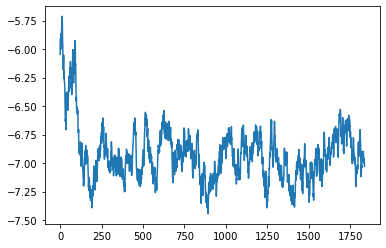

In [24]:
plt.plot(final_rs)

In [6]:
def mprint(*args):
    pr = ""
    args = [[args[i*2], args[i*2+1]] for i in range(len(args)//2)]
    for name, arg in args:
        pr += name + "="
        if type(arg) == int:
            arg = float(arg)
        try:
            arg = arg.item()
        except:
            nista = True
        if type(arg) == float:
            pr += format(arg, '5.2f') + "   "
        else:
            pr += str(arg) + "   "
    print(pr)

In [7]:
env.close()


In [8]:
class LowPassFilter():
    def __init__(self, alfa):
        self.init_value = -1.124525785
        self.val = self.init_value
        self.alfa = alfa
    def step(self, newval):
        if self.val == self.init_value:
            self.val = newval
        self.val = self.val*self.alfa + newval*(1-self.alfa)

tensor([0, 2, 1])

In [16]:
env.close()
print("hha")

hha


In [105]:
obs = env.reset()
action = env.action_space.sample()
import random
import time
lpf = LowPassFilter(1-1/30)
for i in range(420):
    if random.uniform(0, 1) < 0:
        action = pi.explore(obs, 0.03)
    obs, rewards, dones, info = env.step(action)
    lpf.step(rewards)
    env.render()
    time.sleep(0.05)
    print(rewards, lpf.val, end='\r')
env.close()

In [96]:
obs = env.reset()
import time
for i in range(200):
    action= pi.explore(obs, 0.4)#" model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    print(rewards, end='\r')
    env.render()
    time.sleep(0.05)
    
env.close()

In [18]:
env.close()

In [19]:


import gym
import numpy as np

from stable_baselines3 import TD3
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

env = gym.make('Pendulum-v0')

# The noise objects for TD3
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = TD3(MlpPolicy, env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=10000, log_interval=10)
model.save("td3_pendulum")
env = model.get_env()

del model # remove to demonstrate saving and loading

model = TD3.load("td3_pendulum")

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()



Using cpu device
Wrapping the env in a DummyVecEnv.


KeyboardInterrupt: 